In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import ROOT as rt
import root_numpy as rtnp

Welcome to JupyROOT 6.12/06


In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [4]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import keras
print keras.__version__

Using TensorFlow backend.


2.2.2


# Get the samples

In [5]:
hlf_features = ['HT', 'MET', 'PhiMET', 'MT', 'nJets', 'bJets',
                'allJetMass', 'LepPt', 'LepEta', 'LepPhi', 'LepIsoCh',
                'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 'LepIsEle', 'nMu',
                'allMuMass', 'allMuPt', 'nEle', 'allEleMass', 'allElePt', 'nChHad',
                'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'MET', 'MT', 'allJetMass',
                       'allMuPt','allElePt',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'LepEta',
                       
                       'LepCharge','LepIsEle', 
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 'nChHad', 'nNeuHad', 'nPhoton']

Nf_lognorm = 10
Nf_gauss = 1
Nf_binomial = 2
Nf_poisson = 7

In [6]:
sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)

print 'Activated HLF:'
for n in np.array(hlf_features)[sel]:
    print '\t', n

Activated HLF:
	HT
	MET
	MT
	allJetMass
	allMuPt
	allElePt
	LepPt
	LepIsoCh
	LepIsoGamma
	LepIsoNeu
	LepEta
	LepCharge
	LepIsEle
	nMu
	nJets
	bJets
	nEle
	nChHad
	nNeuHad
	nPhoton


In [7]:
data_folder = '../../data/'
SampleName = 'ttbar'
N_train = int(1e6)


raw_sample = np.load(data_folder+SampleName+'_lepFilter_13TeV_sample.npy')
x_train = raw_sample[:N_train, sel]

print raw_sample.shape, x_train.shape

(3003158, 24) (1000000, 20)


# Start the VAE declaration

In [8]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 50
act_fun = 'relu'
clip_x_to0 = 1e-4

In [9]:
def InverseSquareRootLinearUnit(args, min_value = 5e-3):
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1+K.square(args))))

def ClippedTanh(x):
    return 0.5*(1+0.999*K.tanh(x))

In [10]:
x_DNN_input = Input(shape=(original_dim,))
hidden_1 = Dense(intermediate_dim, activation=act_fun)(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun)(hidden_1)
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)

L_z_mean = Dense(latent_dim)(hidden_2)

L_z_sigma_preActivation = Dense(latent_dim)(hidden_2)
L_z_sigma = Lambda(InverseSquareRootLinearUnit)(L_z_sigma_preActivation)

In [11]:
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + z_sigma * epsilon

L_z_latent_DNN = Lambda(sampling)([L_z_mean, L_z_sigma])

In [12]:
decoder_h1 = Dense(intermediate_dim, activation=act_fun)(L_z_latent_DNN)
decoder_h2 = Dense(intermediate_dim, activation=act_fun)(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
L_par1 = Dense(original_dim)(decoder_h2)

L_par2_preActivation = Dense(Nf_lognorm + Nf_gauss)(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit)(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm)(decoder_h2)
L_par3 = Lambda(ClippedTanh)(L_par3_preActivation)

Custom loss function

In [13]:
def KL_loss_forVAE(mu, sigma):
    kl_loss = - 0.5 * K.sum(1 + 2*K.log(sigma) - K.square(mu) - K.square(sigma), axis=-1)
    return K.mean(kl_loss)

def RecoProb_forVAE(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = K.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma) 
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma))
                           )
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_gauss] - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*K.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -K.tf.where(K.equal(x[:, N: N+Nf_binomial],1), K.log(p), K.log(1-p))
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
    single_NLL = K.tf.lgamma(x[:, N:]+1) - x[:, N:]*K.log(mu) + mu
    nll_loss += K.sum(single_NLL, axis=-1)
    
    return K.mean(nll_loss)

def LossVAE(y_train, NETout):
    mu = NETout[:, :latent_dim]
    N = latent_dim
    
    sigma = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss]
    N += Nf_lognorm+Nf_gauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return KL_loss_forVAE(mu, sigma) + RecoProb_forVAE(y_train, par1, par2, par3)

In [14]:
def RecoProb_metric(y_train, NETout):
    N = latent_dim
    N += latent_dim
    
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss]
    N += Nf_lognorm+Nf_gauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return RecoProb_forVAE(y_train, par1, par2, par3)

def KL_loss_metric(y_train, NETout):
    mu = NETout[:, :latent_dim]
    sigma = NETout[:, latent_dim:2*latent_dim]
    return KL_loss_forVAE(mu, sigma)

In [15]:
global_outputs = KL.concatenate([L_z_mean, L_z_sigma, L_par1, L_par2, L_par3])

vae = Model(inputs=x_DNN_input, outputs=global_outputs)
# rms_prop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer='adam', loss=LossVAE, metrics=[RecoProb_metric, KL_loss_metric])
# print vae.summary()

# Training

In [16]:
fit_report = vae.fit(x=x_train, y=x_train,
        validation_split = 0.2,
        shuffle=True,
        epochs=100,
        batch_size=200,
        callbacks = [
                        EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=0.1),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_delta=0.3, verbose=1),
                        TerminateOnNaN()
            ])

Train on 800000 samples, validate on 200000 samples
Epoch 1/100
800000/800000 [==============================] - 28s 34us/step - loss: 42255.2360 - RecoProb_metric: 41773.3837 - KL_loss_metric: 481.8515 - val_loss: 147.3812 - val_RecoProb_metric: 75.4765 - val_KL_loss_metric: 71.9047
Epoch 2/100
800000/800000 [==============================] - 25s 31us/step - loss: 120.7179 - RecoProb_metric: 68.1870 - KL_loss_metric: 52.5309 - val_loss: 94.4156 - val_RecoProb_metric: 59.3384 - val_KL_loss_metric: 35.0773
Epoch 3/100
800000/800000 [==============================] - 27s 33us/step - loss: 83.9882 - RecoProb_metric: 55.8804 - KL_loss_metric: 28.1079 - val_loss: 76.3510 - val_RecoProb_metric: 52.6613 - val_KL_loss_metric: 23.6896
Epoch 4/100
800000/800000 [==============================] - 27s 34us/step - loss: 68.7228 - RecoProb_metric: 50.8006 - KL_loss_metric: 17.9221 - val_loss: 74.4128 - val_RecoProb_metric: 56.5236 - val_KL_loss_metric: 17.8892
Epoch 5/100
800000/800000 [============

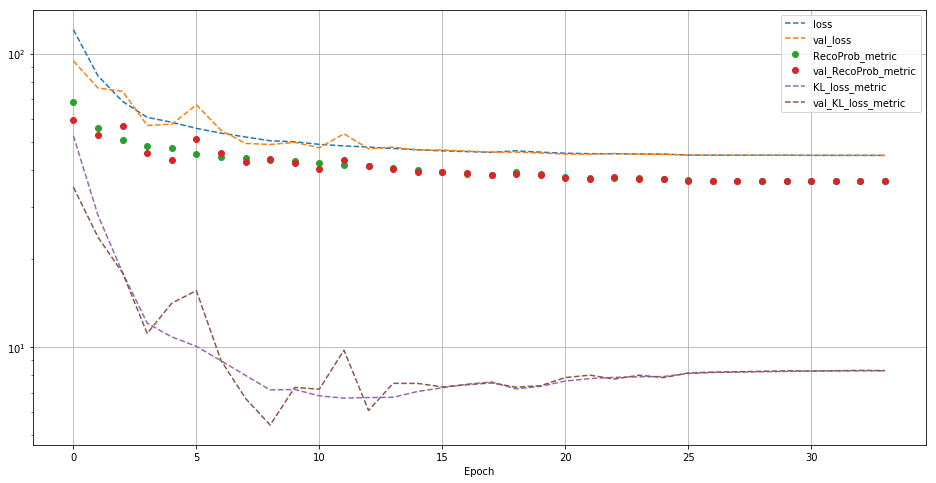

In [44]:
%matplotlib inline
f = plt.figure(figsize=(16,8))
style = {'loss':'--', 'RecoProb_metric': 'o', 'KL_loss_metric': '--'}
for item in ['loss', 'RecoProb_metric', 'KL_loss_metric']:
    plt.semilogy(np.array(fit_report.history[item][:])[1:], style[item], label=item)
    plt.semilogy(np.array(fit_report.history['val_'+item][:])[1:], style[item], label='val_'+item)

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')

In [18]:
vae.save('last_saved_VAE.h5')
custom_objects = {
    'original_dim': x_train.shape[1],
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'Nf_gauss' : Nf_gauss,
    'Nf_binomial' : Nf_binomial,
    'Nf_poisson' : Nf_poisson,
    'LossVAE': LossVAE,
    'RecoProb_metric': RecoProb_metric,
    'KL_loss_metric': KL_loss_metric    
}

In [19]:
if 0:
    from keras.models import load_model
    vae = load_model('last_saved_VAE.h5', custom_objects=custom_objects)
    print 'Loaded'

### Build encoder and decoder

In [20]:
encoder = Model(inputs=x_DNN_input, outputs=[L_z_mean, L_z_sigma])
encoder.save('saved_Encoder.h5')

# Validation

Gather the signal data

In [21]:
data_folder = '../../data/'

BSM_samples = ['AtoChHW', 'AtoChHW_HIGHMASS', 'Ato4l', 'Zprime', 'Wprime', 'qcd', 'Wlnu']

x_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train, sel]

### Predict latent space

In [22]:
x_train_encoded = np.array(encoder.predict(x_train))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    print k
    x_sig_encoded[k] = np.array(encoder.predict(v))

AtoChHW_HIGHMASS
Ato4l
Wlnu
AtoChHW
Wprime
qcd
Zprime


Latent space mean distribution

In [23]:
def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

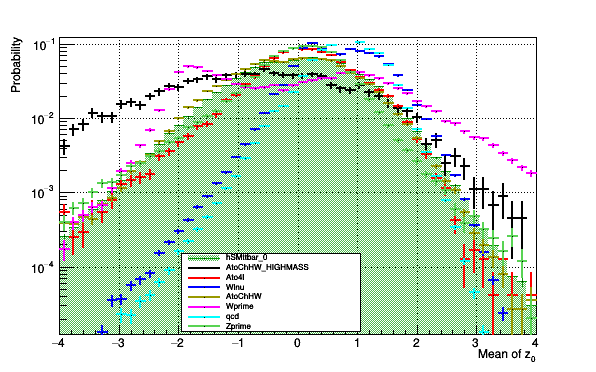

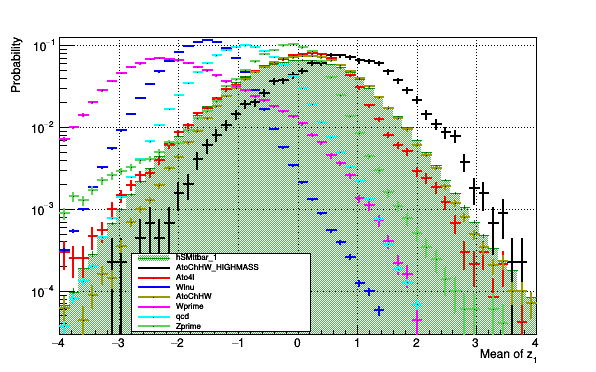

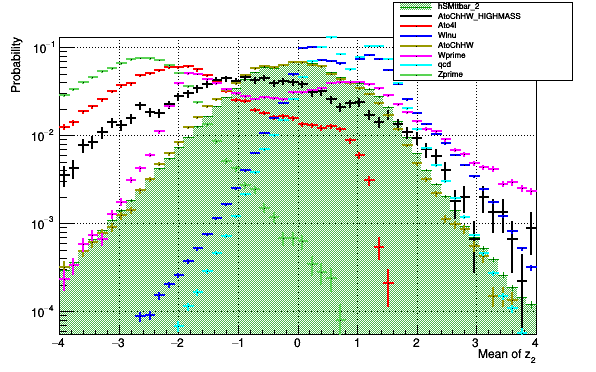

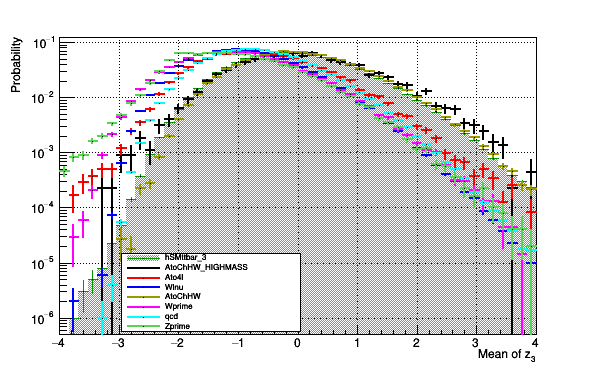

In [24]:
histos = []
canvases = []
binning = [50, -4, 4]

for kk in range(latent_dim):
    c = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)

    h = rt.TH1F('hSM{}_{}'.format(SampleName, kk), SampleName, binning[0], binning[1], binning[2])
    z = x_train_encoded[0, :, kk]
    rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))
    h.SetStats(0)
    h.SetLineColor(rt.kGreen+4-2)
    h.SetFillColorAlpha(rt.kGreen+4-2, 0.7)
    h.SetFillStyle(3001)
    
    h.SetTitle('')
    h.SetXTitle('Mean of z_{'+str(kk)+'}')
    h.SetYTitle('Probability')
    
    h.Draw('Bar SAME')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8]
    # fill
    for i, n in enumerate(x_sig.keys()):
        h = rt.TH1F('hBSM{}_{}'.format(i, kk), n, binning[0], binning[1], binning[2])
        z = x_sig_encoded[n][0, :, kk]
        rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)

    c.BuildLegend()
    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)

## Recostruction sum of pdf

In [25]:
autoencoder = Model(inputs=x_DNN_input, outputs=[L_par1, L_par2, L_par3])
autoencoder.save('saved_Encoder.h5')

In [26]:
pars_ae_train = autoencoder.predict(x_train)
# print pars_ae_train.shape

pars_ae_sig = {}
for k,v in x_sig.iteritems():
    print k
    pars_ae_sig[k] = autoencoder.predict(v)

AtoChHW_HIGHMASS
Ato4l
Wlnu
AtoChHW
Wprime
qcd
Zprime


In [27]:
def sum_of_possion(x_in, mu_vec):
    out = np.zeros_like(x_in)
    for i, aux in enumerate(x_in):
        out[i] = np.sum(poisson.pmf(aux, mu_vec))
    return out

In [28]:
def sum_of_lognorm(x, f, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    
    x_clipped = np.clip(x, clip_x_to0, 1e8)
    x_norm = (np.log(x_clipped) - mu_vec)/sigma_vec
    single_prob = np.where(np.less(x, clip_x_to0),
                               f,
                               (1-f)*np.exp(-0.5*np.square(x_norm))/(x_clipped*sigma_vec*np.sqrt(2*np.pi))
    )
    return np.sum(single_prob, axis=1)/mu_vec.shape[0]

HT
MET
MT
allJetMass
allMuPt
allElePt
LepPt
LepIsoCh
LepIsoGamma
LepIsoNeu
LepEta
LepCharge
LepIsEle
nMu
nJets
bJets
nEle
nChHad
nNeuHad
nPhoton


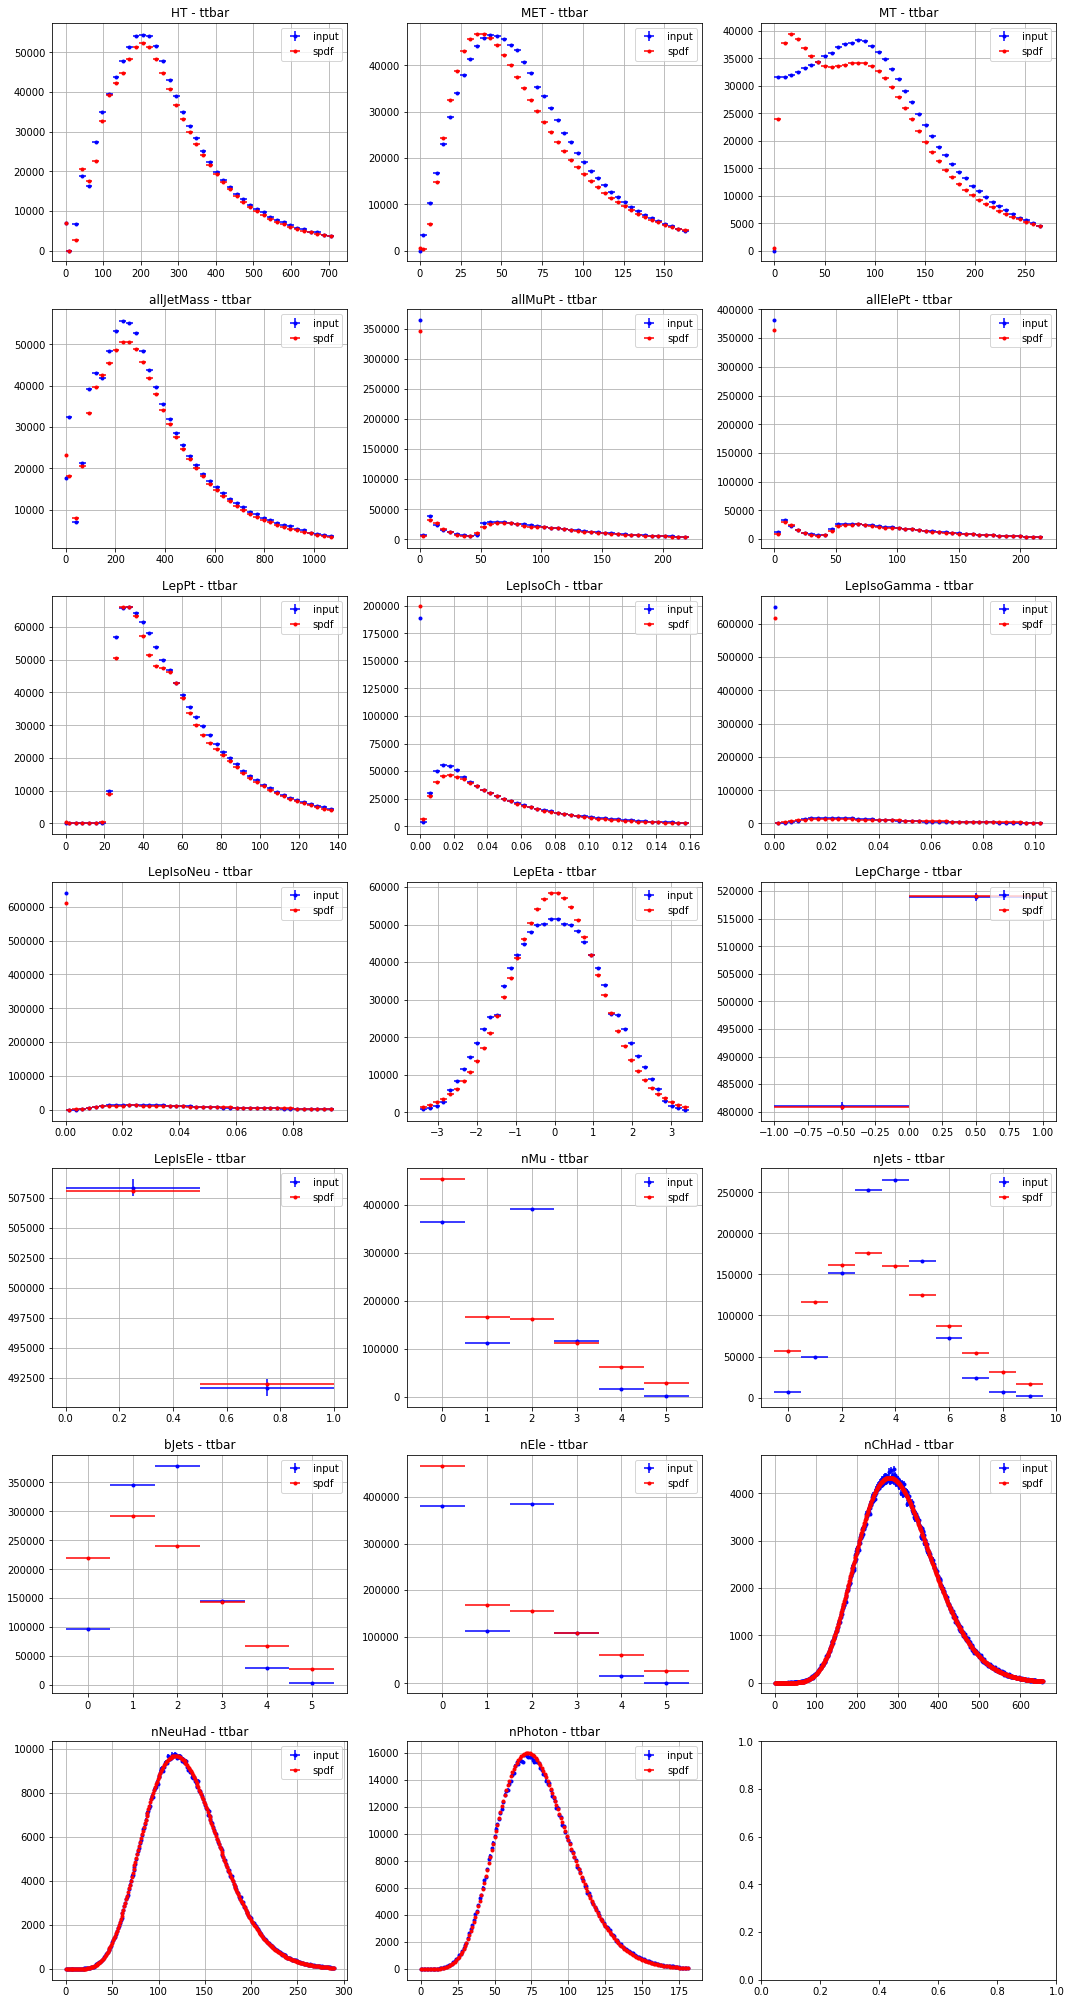

In [33]:
f, ax_arr = plt.subplots(1+int(len(active_hlf_features)/3.),3 , figsize=(18,36))

for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
#     plt.yscale('log', nonposy='clip')
    
    #Plot distribution of the variable
    x_aux = x_train[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 95.))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[1:]))
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = (bincenters[10]-bincenters[9])*np.ones_like(bincenters)
        bin_width[0] = 1.

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        f_vec = pars_ae_train[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
#             print np.sum(bin_content)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
#             print np.sum(bin_content)
    elif i < Nf_lognorm + Nf_gauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_train[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_train[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - ' + SampleName)        
    ax_arr[i/3, i%3].legend(loc='best')
        
plt.show()

# Test Statistics with Losses

In [30]:
from scipy.special import loggamma

In [40]:
def numpy_KL_loss(mu, sigma):
    kl_loss = - 0.5 * np.sum(1 + 2*np.log(sigma) - np.square(mu) - np.square(sigma), axis=-1)
    return kl_loss

def numpy_RecoProb(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = np.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = np.where(np.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -np.log(fraction),
                                -np.log(1-fraction)
                                + np.log(sigma) 
                                + np.log(x_clipped)
                                + 0.5*np.square((np.log(x_clipped) - mu) / sigma)
                           )
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = (x[:,N:N+Nf_gauss] - mu)/sigma
    single_NLL = np.log(sigma) + 0.5*np.square(norm_x)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*np.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -np.where(np.equal(x[:, N: N+Nf_binomial],1), np.log(p), np.log(1-p))
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + np.where(np.greater(aux, 0), aux, aux/np.sqrt(1+np.square(aux)))
    single_NLL = loggamma(x[:, N:]+1) - x[:, N:]*np.log(mu) + mu
    nll_loss += np.sum(single_NLL, axis=-1)
    
    return nll_loss

def numpy_loss(x, x_encoded, pars_ae):
    mu = x_encoded[0]
    sigma = x_encoded[1]    
    kl_loss = numpy_KL_loss(mu, sigma)
    
    nll_loss = numpy_RecoProb(x, pars_ae[0], pars_ae[1], pars_ae[2])
    
    return [nll_loss + kl_loss, nll_loss, kl_loss]

In [41]:
loss_train = numpy_loss(x_train, x_train_encoded, pars_ae_train)

loss_sig = {}
for n in x_sig.keys():
    print n
    loss_sig[n] = numpy_loss(x_sig[n], x_sig_encoded[n], pars_ae_sig[n])

AtoChHW_HIGHMASS
Ato4l
Wlnu
AtoChHW
Wprime
qcd
Zprime


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0
Warning in <TROOT::Append>: Replacing existing TH1: h_loss_SMttbar_0 (Potential memory leak).


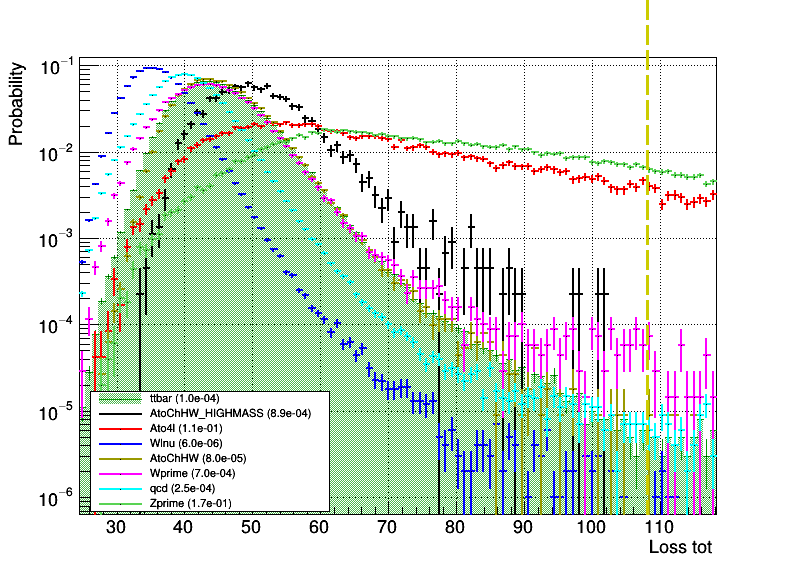

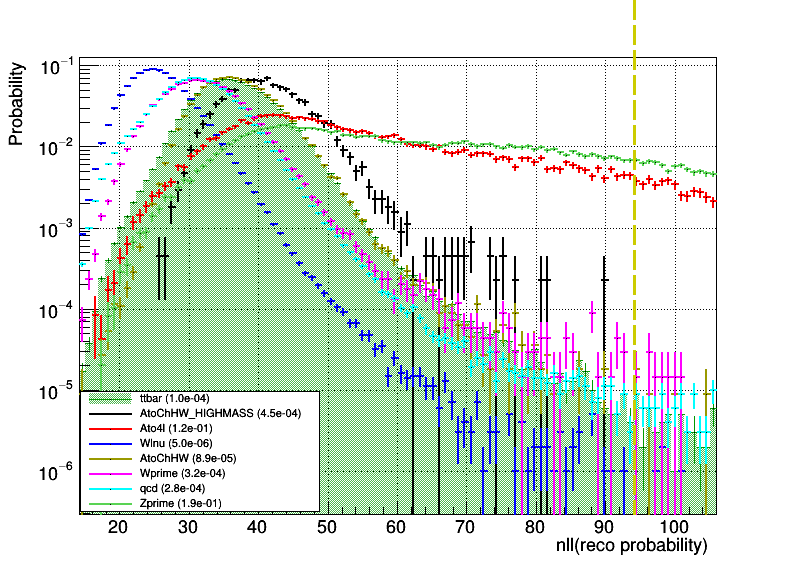

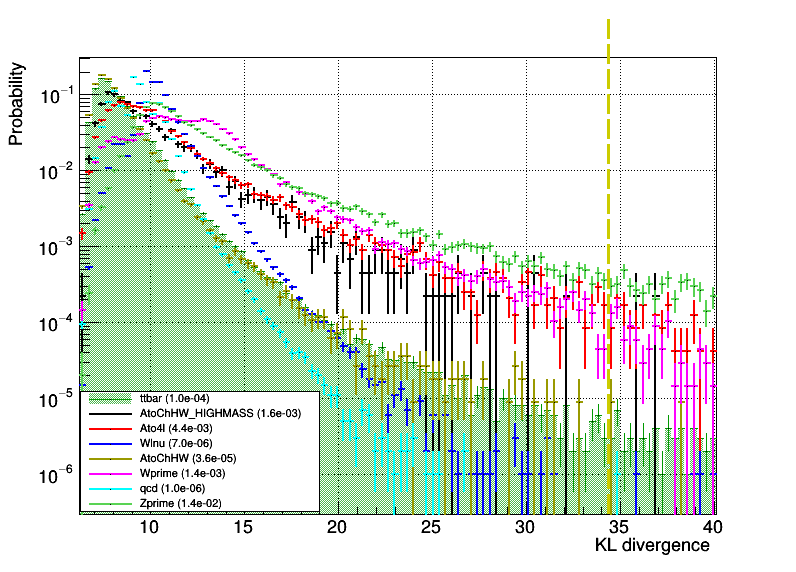

In [43]:
histos = []
canvases = []

for loss_piece in range(3):
    binning = [100, np.min(loss_train[loss_piece]), np.percentile(loss_train[loss_piece], 100*(1-5e-5))]

    c = rt.TCanvas('c'+str(loss_piece), 'c'+str(loss_piece), 800, 600)


    h = rt.TH1F('h_loss_SM{}_{}'.format(SampleName, loss_piece), SampleName, binning[0], binning[1], binning[2])
    rtnp.fill_hist(h, loss_train[loss_piece])
    h.Scale(1./loss_train[loss_piece].shape[0])

    h.SetStats(0)
    h.SetLineColor(rt.kGreen+4-2)
    h.SetFillColorAlpha(rt.kGreen+4-2, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)

    val_to_cut = np.percentile(loss_train[loss_piece], 100*(1-1e-4))
    h.SetTitle(h.GetTitle()+' ({:1.1e})'.format(1e-4))
#     print val_to_cut





    colors = [1,2,4,rt.kYellow+2,6,7, 8]
    # fill
    for i, n in enumerate(x_sig.keys()):
        z = loss_sig[n][loss_piece]
        eff = np.sum(z>val_to_cut)/float(z.shape[0])
#         print n, ': {:1.2e}'.format(eff)
        h1 = rt.TH1F('h_loss_BSM{}_{}'.format(i, loss_piece), n+' ({:1.1e})'.format(eff), binning[0], binning[1], binning[2])
        rtnp.fill_hist(h1, z)
        h1.Scale(1./float(z.shape[0]))

        h1.SetStats(0)
        h1.SetLineColor(colors[i])
        h1.SetLineWidth(2)
        h1.Draw('SAME')
        histos.append(h1)

    c.BuildLegend()
    h.SetTitle('')
    Ytitles = ['Loss tot', 'nll(reco probability)', 'KL divergence']
    h.SetXTitle(Ytitles[loss_piece])
    h.SetYTitle('Probability')

    line = rt.TLine()
    line.SetLineColor(rt.kYellow+1)
    line.SetLineWidth(3)
    line.SetLineStyle(9)
    line.DrawLine(val_to_cut,0, val_to_cut,1)

    c.SetGrid()
    c.SetLogy()
    c.Draw()
    
    canvases.append(c)